# Imports and Config

## Imports

In [1]:
# only needed on colab
#!pip install datasets[vision]

In [1]:
import numpy as np
import pandas as pd
import os
import random
import re
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import textwrap
import random
from tqdm.notebook import tqdm
import json
import zipfile
import io

from datasets import load_dataset

import torch
from torchvision import transforms

## Data Loading

### WikiArt Artist Data


In [2]:
# load in wikiart artist information
artists_info = pd.read_csv('data/artists.csv')

In [3]:
artist_names = set(list(artists_info['Name'].str.strip().str.lower()))

In [5]:
movements = set(artists_info['ArtMovements'].str.split(',').explode().str.strip().str.lower().value_counts()[:15].index.tolist())

In [6]:
movements

{'abstract art',
 'abstract expressionism',
 'academic art',
 'art nouveau',
 'baroque',
 'conceptual art',
 'contemporary',
 'expressionism',
 'impressionism',
 'minimalism',
 'pop art',
 'post-impressionism',
 'realism',
 'romanticism',
 'surrealism'}

In [7]:
genres = set(artists_info['Genres'].str.split(',').explode().str.strip().str.lower().value_counts()[:15].index.tolist())

In [8]:
genres

{'abstract',
 'animal painting',
 'cityscape',
 'figurative',
 'genre painting',
 'history painting',
 'illustration',
 'installation',
 'landscape',
 'marina',
 'photo',
 'portrait',
 'religious painting',
 'sculpture',
 'still life'}

### DiffusionDB Data

In [4]:
# Load diffusionDB - first 100k images
gen_imgs = load_dataset('poloclub/diffusiondb', '2m_first_100k')
# load only img and prompt
gen_imgs = gen_imgs['train'].select_columns(['prompt', 'image'])

## Data Sampling
Defines a helper function to take a random slice of data and plot it

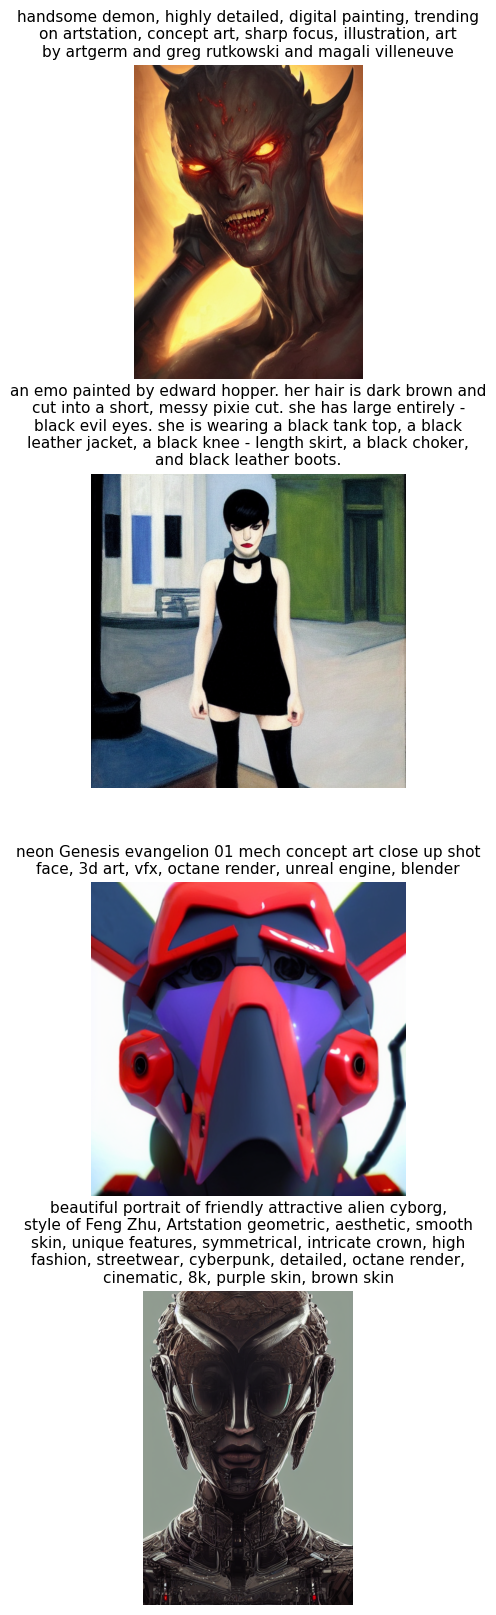

In [10]:
def sample_data(indices, data):
  # helper function to show prompt and image
    num_rows = len(indices)

    # Create a new figure with subplots
    fig, axes = plt.subplots(num_rows, 1, figsize=(5, 5 * num_rows))

    # Iterate over the indices and plot images with wrapped titles
    for i, index in enumerate(indices):
        prompt = data[int(index)]['prompt']
        img = data[int(index)]['image']

        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')

        # Wrap the prompt text to fit the width of the plot
        wrapped_text = textwrap.fill(prompt, width=60)  # Adjust the width as needed

        # Set the wrapped title of the subplot
        axes[i].set_title(wrapped_text, fontsize=11, ha='center')
    # add space to accomodate titles
    plt.subplots_adjust(hspace=0.3)

    # Show the plot
    plt.show()

def get_random_samples(sample_size, data):
  # function to get random promts and images
  random_indices = np.random.randint(0, len(data), sample_size)
  sample_data(random_indices, data)

  return data.select([int(i) for i in random_indices])

random_samples = get_random_samples(4, gen_imgs)

## Data Filtering

In [ ]:
# filter the data based on prompts with positive search terms and negative negation terms
filtered_rowsets = []
negation_terms = ['3d', 'sci-fi', 'digital', 'photo', 'photograph', 'photography', 'render', '4k', 'deviantart', 'cinematic', '4 k', 'cyberpunk']
art_terms = ['on canvas', 'oil painting', 'watercolours', 'watercolors', 'watercolor','acrylic', 'brush strokes', 'painting']
for filter_terms in [artist_names, genres, art_terms]:
  # filter positively on filter terms
  filtered = gen_imgs.filter(lambda x: any(s in x['prompt'].lower() for s in filter_terms))
  # filter negatively on negation terms
  filtered = filtered.filter(lambda x: not any(s in x['prompt'].lower() for s in negation_terms))
  filtered_rowsets.append(filtered)

In [5]:
negation_terms = ['3d', 'sci-fi', 'digital', 'photo', 'photograph', 'photography', 'render', '4k', 'deviantart', 'cinematic', '4 k', 'cyberpunk']
filtered = gen_imgs.filter(lambda x: any(s in x['prompt'].lower() for s in artist_names))
# filter negatively on negation terms
filtered_dataset = filtered.filter(lambda x: not any(s in x['prompt'].lower() for s in negation_terms))

Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/33515 [00:00<?, ? examples/s]

### Filtered data based on artist names
Here data is filtered based on it containing references to any artists contained in the wikiArt dataset

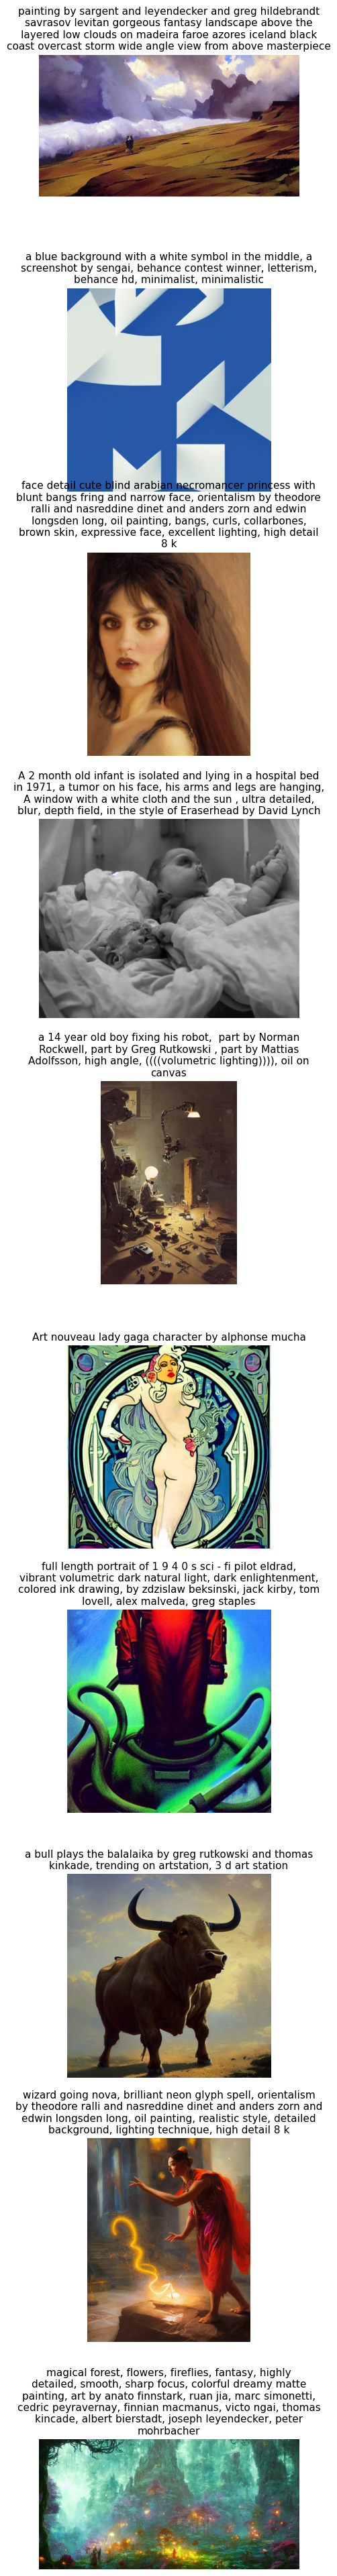

In [ ]:
random_artists = get_random_samples(10, filtered_rowsets[0])

### Filtered data based on art genres
Data here is filtered based on the prompt containing keywords consisting of the top 10 most frequently used genre of art an artist belongs to according to WikiArt

/home/rmohe01/miniforge3/envs/MIE1517_Project/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


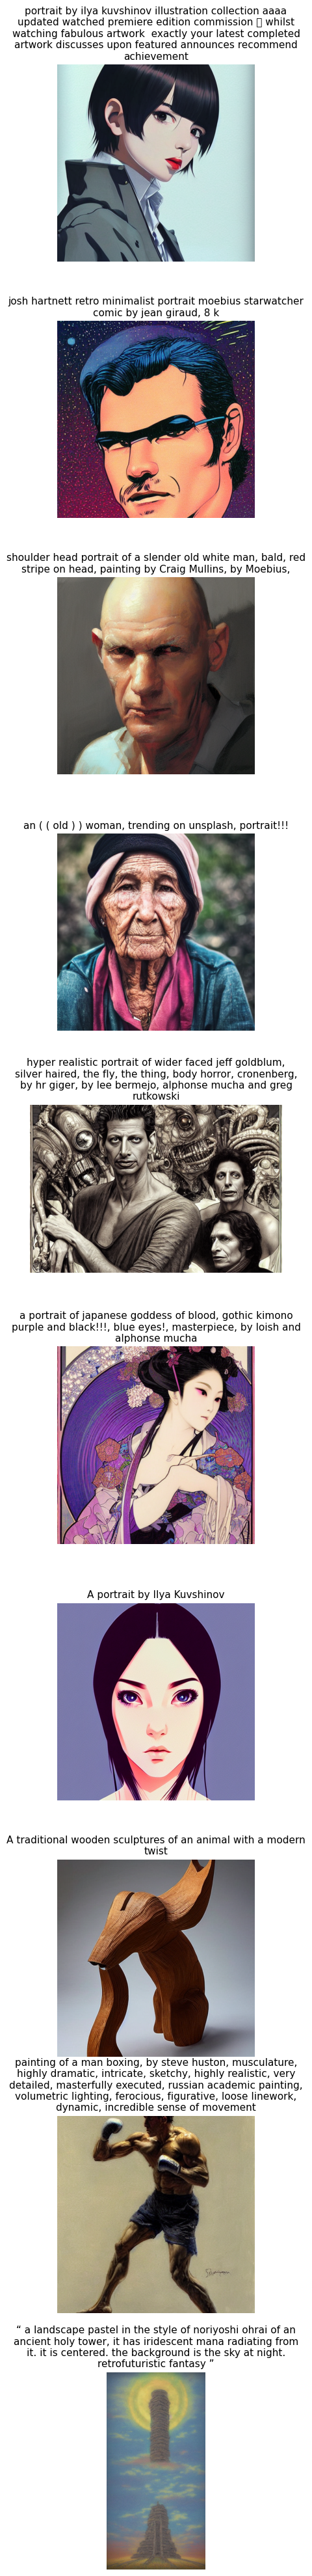

In [ ]:
random_genres = get_random_samples(10, filtered_rowsets[1])

### Filtered data based on art-words
Here data is filtered based on art keywords like oil painting, canvas, etc

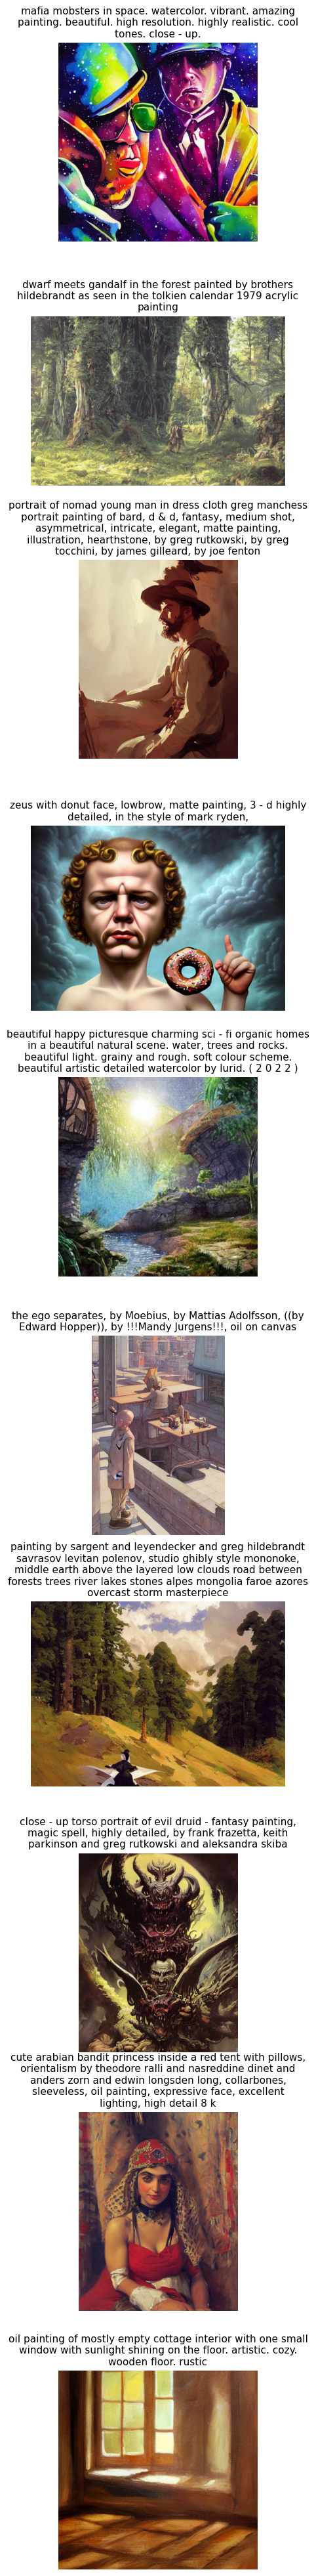

In [ ]:
random_art_terms = get_random_samples(10, filtered_rowsets[2])

## Image Augmentation 

In [6]:
def crop_and_export_to_zip(zip_filename, data, crop_size=(512, 512)):
    '''
    Helper function to crop and compress images for exporting into a smaller dataset
    '''
    # Create a zip file
    with zipfile.ZipFile(zip_filename, 'w') as zip_file:
        # Loop through all the images in the dataset
        for i, row in tqdm(enumerate(data)):
            # get the image
            img = row['image']
            # get the side information (everything in the row but the image)
            side_info = row.copy()
            side_info.pop('image')
            image_filename = f"cropped_image_{i}.jpg"
            json_filename = f"cropped_image_{i}.json"

            # Get the dimensions of the image
            img_width, img_height = img.size
            
            # Calculate the largest possible square crop
            min_dim = min(img_width, img_height)
            crop_width, crop_height = min_dim, min_dim

            # Check if the image is smaller than the desired crop size
            if min_dim < max(crop_size):
                print(f"Image {i} is too small for the desired crop size.")
                continue

            # Calculate random position for the crop
            left = random.randint(0, img_width - crop_width)
            upper = random.randint(0, img_height - crop_height)

            # Perform the crop
            cropped_img = img.crop((left, upper, left + crop_width, upper + crop_height))

            # Resize the cropped image to the specified size
            cropped_img = cropped_img.resize(crop_size)

            # Convert the cropped image to RGB
            cropped_img = cropped_img.convert('RGB')

            # Save the cropped image in JPEG format with optimization and reduced quality
            img_bytes_io = io.BytesIO()
            cropped_img.save(img_bytes_io, 'JPEG', optimize=True, quality=85)
            img_bytes_io.seek(0)

            # Write the cropped image bytes to the zip file
            zip_file.writestr(image_filename, img_bytes_io.read())

            # Write the side information to a JSON file and add it to the zip file
            zip_file.writestr(json_filename, json.dumps(side_info))

In [7]:
# choose the artist-prompt images as the ones to be exported
export_location = 'data/cropped_diffusiondb_256.zip'
crop_and_export_to_zip(export_location, filtered_dataset, crop_size=(256,256))

0it [00:00, ?it/s]

Image 9875 is too small for the desired crop size.
Image 12323 is too small for the desired crop size.
